In [1]:
# @title Data Reading and processing
import pandas as pd
import os
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multitest import multipletests
import warnings

gene_count_path ='/content/drive/MyDrive/MITResearch/IBD_13/gene.count.matrix.umi.csv'
metadata_path = '/content/drive/MyDrive/MITResearch/IBD_13/sample.metadata.pass.tsv'

# Load gene count matrix
gene_count_df = pd.read_csv(gene_count_path)

# ---- Data Transformation Section ----
# Transpose gene count matrix to align with metaphlan_df data format
gene_count_df = gene_count_df.T

# Set the first row as column names and convert the matrix to a dataframe
new_col_names = gene_count_df.iloc[0]  # First row for column names
gene_count_df = gene_count_df[1:]  # Remove the first row
gene_count_df.columns = new_col_names  # Set new column names
gene_count_df.reset_index(drop=False,inplace=True)
gene_count_df.rename(columns={'index': 'PatientID_Weeknr'}, inplace=True)

meta = pd.read_csv(metadata_path, sep='\t')
meta.rename(columns={'label': 'PatientID_Weeknr'}, inplace=True)


print(f"Initial row count: {len(gene_count_df)}")

gene_count_df = pd.merge(gene_count_df, meta[['PatientID_Weeknr', 'patient', 'week']], how='left', on="PatientID_Weeknr")



print(f"New row count after merge: { len(gene_count_df)}")
cols = ['PatientID_Weeknr','patient', 'week'] + [col for col in gene_count_df.columns if col not in('PatientID_Weeknr','patient', 'week' )]
gene_count_df = gene_count_df[cols]
gene_count_df.rename(columns={'patient': 'patient_id'}, inplace=True)


gene_count_df['PatientID_Weeknr'] = gene_count_df['PatientID_Weeknr'].str.replace("ExfoSeqIBDtracker", "")
gene_count_df.sort_values(by=['patient_id', 'week'], inplace=True)

Initial row count: 605
New row count after merge: 605


In [2]:
# @title
pattern = r'^P\d+w[A-Z]\d+$'

# Check which rows match this pattern
matches = gene_count_df['PatientID_Weeknr'].str.match(pattern)

# Print non-matching values
non_matching_values = gene_count_df.loc[~matches, 'PatientID_Weeknr']
if not non_matching_values.empty:
    print("Values not matching the expected format:")
    print(non_matching_values)
else:
    print("All values match the expected format.")

gene_count_df = gene_count_df[gene_count_df['PatientID_Weeknr'].str.match(pattern)]

gene_count_df['week'] = gene_count_df['week'].str.extract('Week_(\d+)').astype(int)

All values match the expected format.


In [3]:
print(gene_count_df.shape)

(605, 546)


In [4]:
# @title Normalizing to housekeeping genes
# Define columns that should not be converted to numeric and normalized
exclude_columns = [	'PatientID_Weeknr', 'Flare_status', 'patient_id', 'week']

# Convert all other data in DataFrame to numeric types
for column in gene_count_df.columns:
    if column not in exclude_columns:
        gene_count_df[column] = pd.to_numeric(gene_count_df[column], errors='coerce')

# Define your housekeeping gene symbols
house_keeping_genes = ["ACTB", "ATP5F1", "B2M", "GAPDH", "GUSB",
                       "HPRT", "PGK1", "PPIA", "RPS18", "TBP",
                       "TFRC", "YWHAZ"]

# Find columns that start with any of the housekeeping gene symbols and are not in the excluded list
hk_gene_cols = [col for col in gene_count_df.columns
                if any(col.startswith(hk + '_') for hk in house_keeping_genes) and col not in exclude_columns]

# Selecting housekeeping genes data
hk_genes_data = gene_count_df[hk_gene_cols]

# Calculate the geometric mean of the housekeeping genes for each sample
# Adding a small value (e.g., 1e-9) to avoid taking log(0)
geometric_mean_hk = np.exp(np.log(hk_genes_data + 1e-9).mean(axis=1))

# Normalize the entire gene count matrix by the geometric mean of the housekeeping genes
# Apply normalization only to numeric columns
for column in gene_count_df.columns:
    if column not in exclude_columns:
        gene_count_df[column] = gene_count_df[column].div(geometric_mean_hk, axis=0)

# The DataFrame now contains normalized data for numeric columns, excluding specified non-numeric columns.


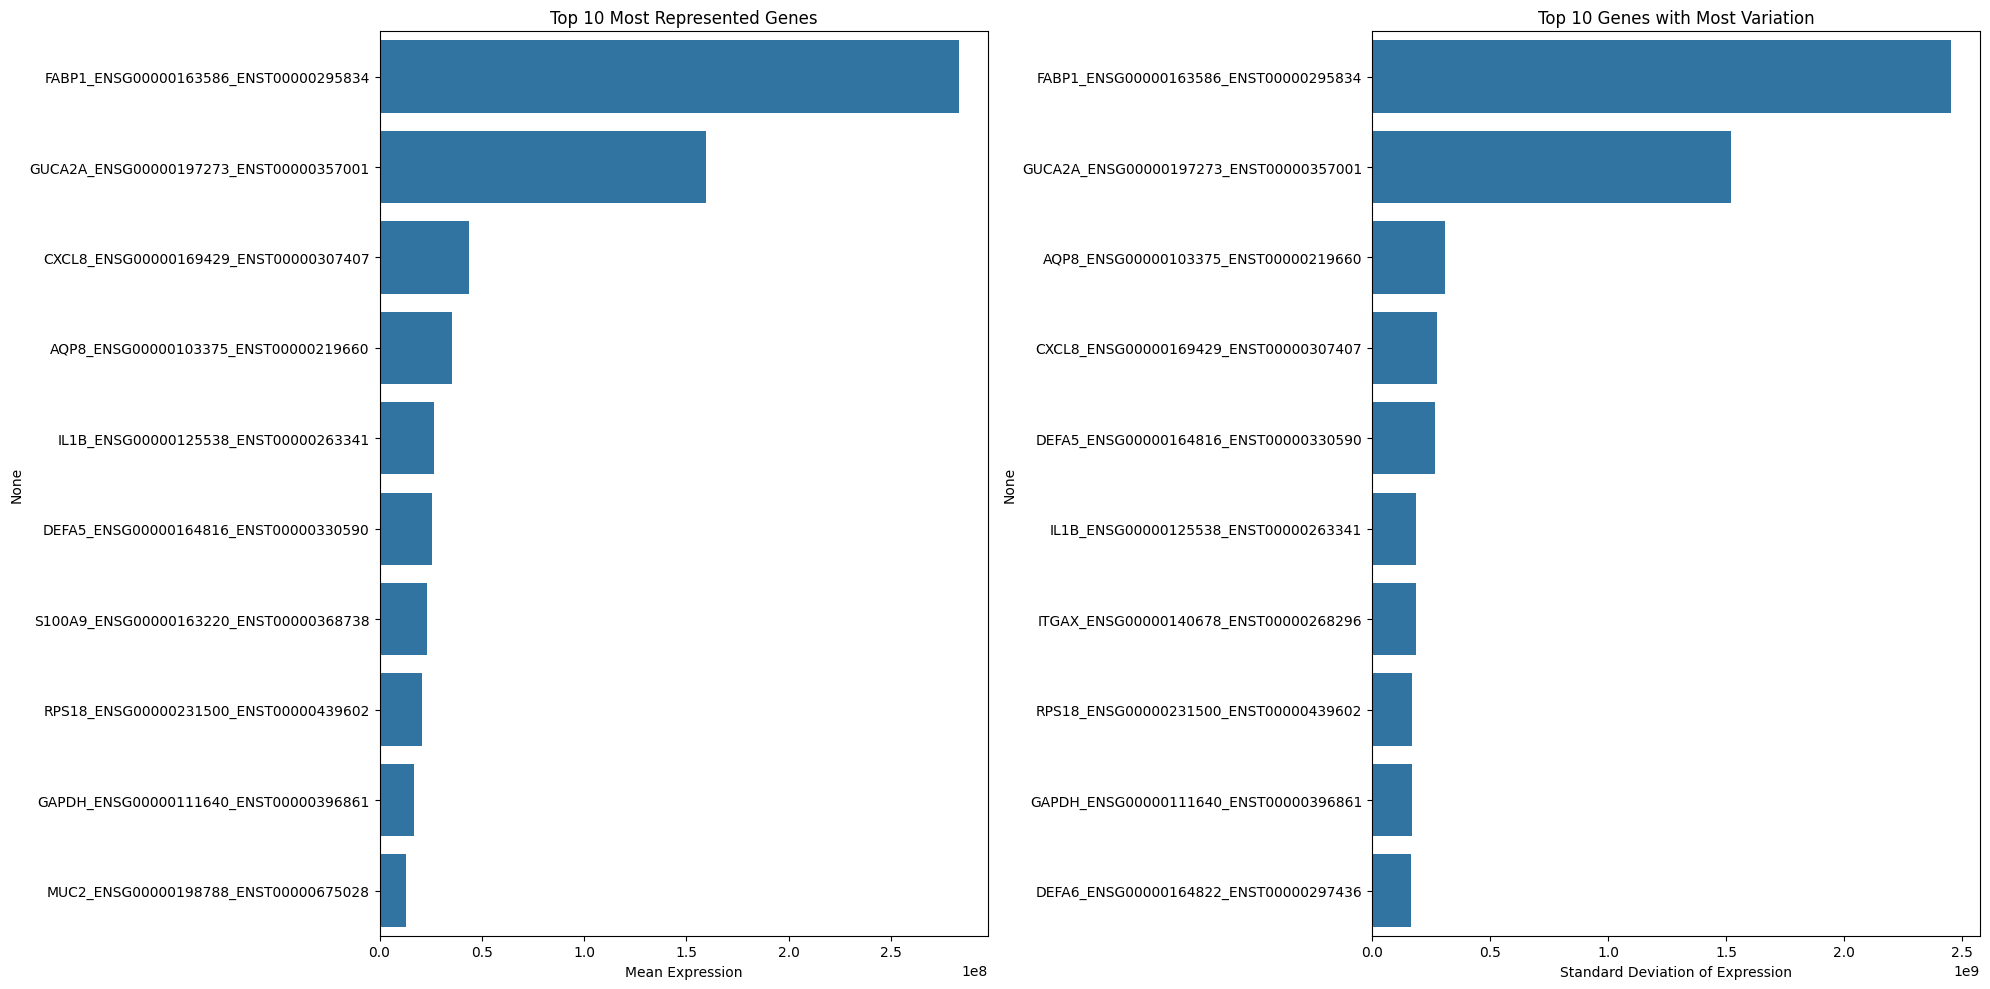

In [5]:
# @title
# Preparing for gene analysis
# Calculate mean and standard deviation for each gene
gene_mean =  gene_count_df.iloc[:, 3:].mean()
gene_std =  gene_count_df.iloc[:, 3:].std()


# Identify the most represented genes (highest mean)
most_represented_genes = gene_mean.sort_values(ascending=False).head(10)

# Identify genes with the most variation (highest standard deviation)
most_variable_genes = gene_std.sort_values(ascending=False).head(10)

# Plotting for genes
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.barplot(x=most_represented_genes.values, y=most_represented_genes.index)
plt.title('Top 10 Most Represented Genes')
plt.xlabel('Mean Expression')

plt.subplot(1, 2, 2)
sns.barplot(x=most_variable_genes.values, y=most_variable_genes.index)
plt.title('Top 10 Genes with Most Variation')
plt.xlabel('Standard Deviation of Expression')

plt.tight_layout()
plt.show()

Patient 2102 had a flair from week 16 to 24
Patient 2101 had a flair from week 25 to 43
Patient 2103 had a flair from week 27 to 39

In [6]:
gene_count_df['patient_id'].drop_duplicates()

0      TR_2101
46     TR_2102
86     TR_2103
133    TR_2104
184    TR_2105
232    TR_2106
281    TR_2107
329    TR_2108
367    TR_2201
414    TR_2202
462    TR_2203
510    TR_2204
556    TR_2205
Name: patient_id, dtype: object

In [7]:
# @title
for patient in gene_count_df['patient_id'].unique():
    patient_data = gene_count_df[gene_count_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-gene expression columns to focus on gene data
    #gene_data = patient_data.drop(['patient_id', 'week', 'Flare_status', 'PatientID_Weeknr'], axis=1)
    gene_data = patient_data.drop(['patient_id', 'week', 'PatientID_Weeknr'], axis=1)

    # Find the 10 genes with the highest average expression for the current patient
    top_genes = gene_data.mean().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 7))

    # Plot the expression over time for the top 10 genes
    for gene in top_genes:
        sns.lineplot(data=patient_data, x='week', y=gene, label=gene)

    # Annotate flare status changes (if applicable)
    #flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
    #for _, (week, status) in flare_changes.iterrows():
     #   plt.axvline(x=week, color='grey', linestyle='--')
     #   plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Top 10 Gene Expression Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Expression Level')
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title
for patient in gene_count_df['patient_id'].unique():
    patient_data = gene_count_df[gene_count_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-gene expression columns to focus on gene data
    #gene_data = patient_data.drop(['patient_id', 'week', 'Flare_status' , 'PatientID_Weeknr'], axis=1)
    gene_data = patient_data.drop(['patient_id', 'week',  'PatientID_Weeknr'], axis=1)

    # Find the 10 genes with the most variation (highest standard deviation) for the current patient
    top_genes = gene_data.std().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 7))

    # Plot the expression over time for the top 10 genes with the most variation
    for gene in top_genes:
        sns.lineplot(data=patient_data, x='week', y=gene, label=gene)

    # Annotate flare status changes (if applicable)
   # flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
   # for _, (week, status) in flare_changes.iterrows():
  #    plt.axvline(x=week, color='grey', linestyle='--')
  #   plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Top 10 Genes with Most Variation Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Expression Level')
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

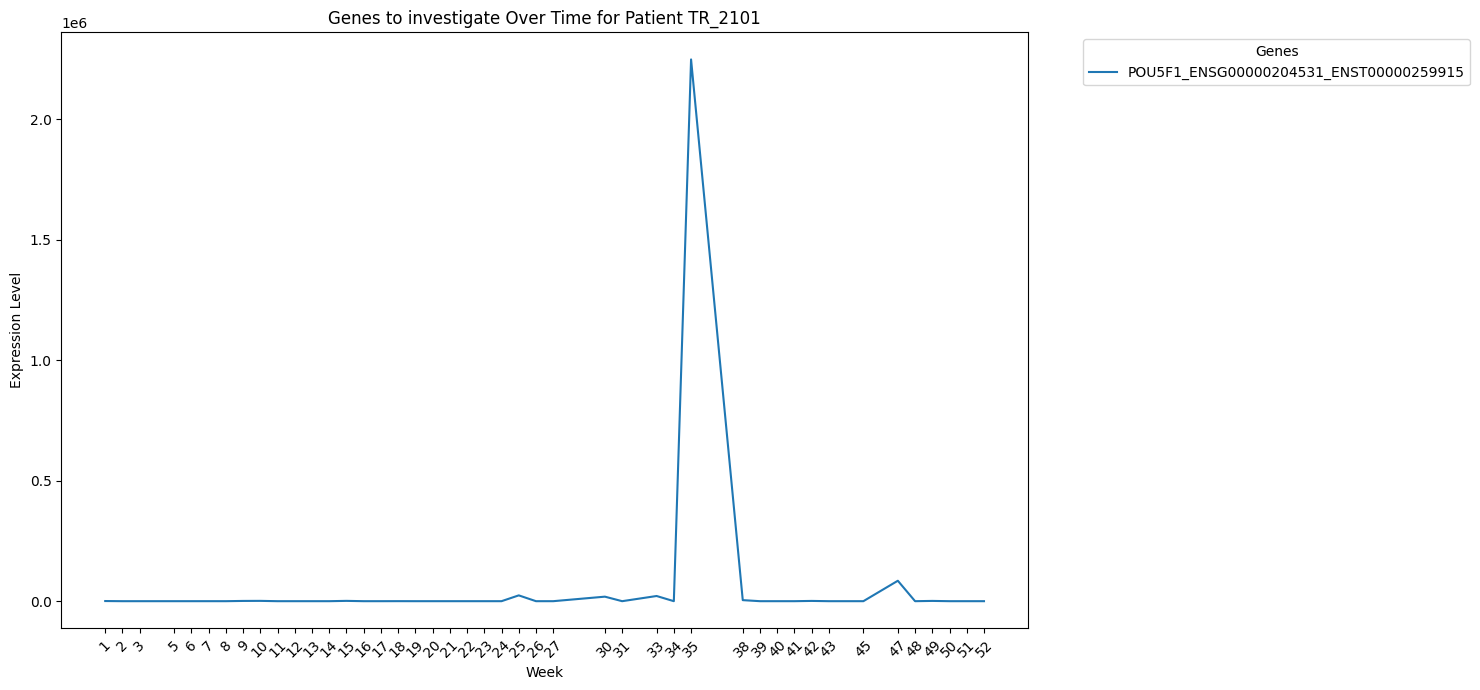

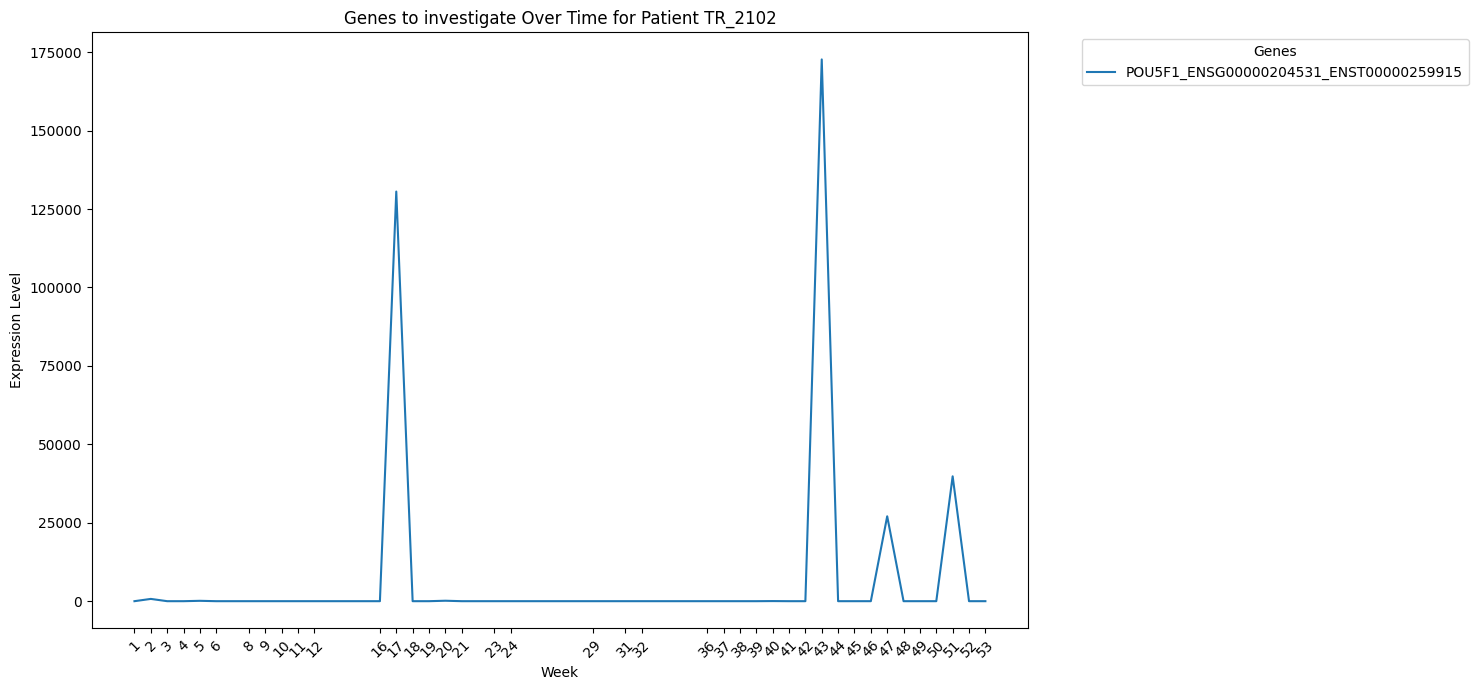

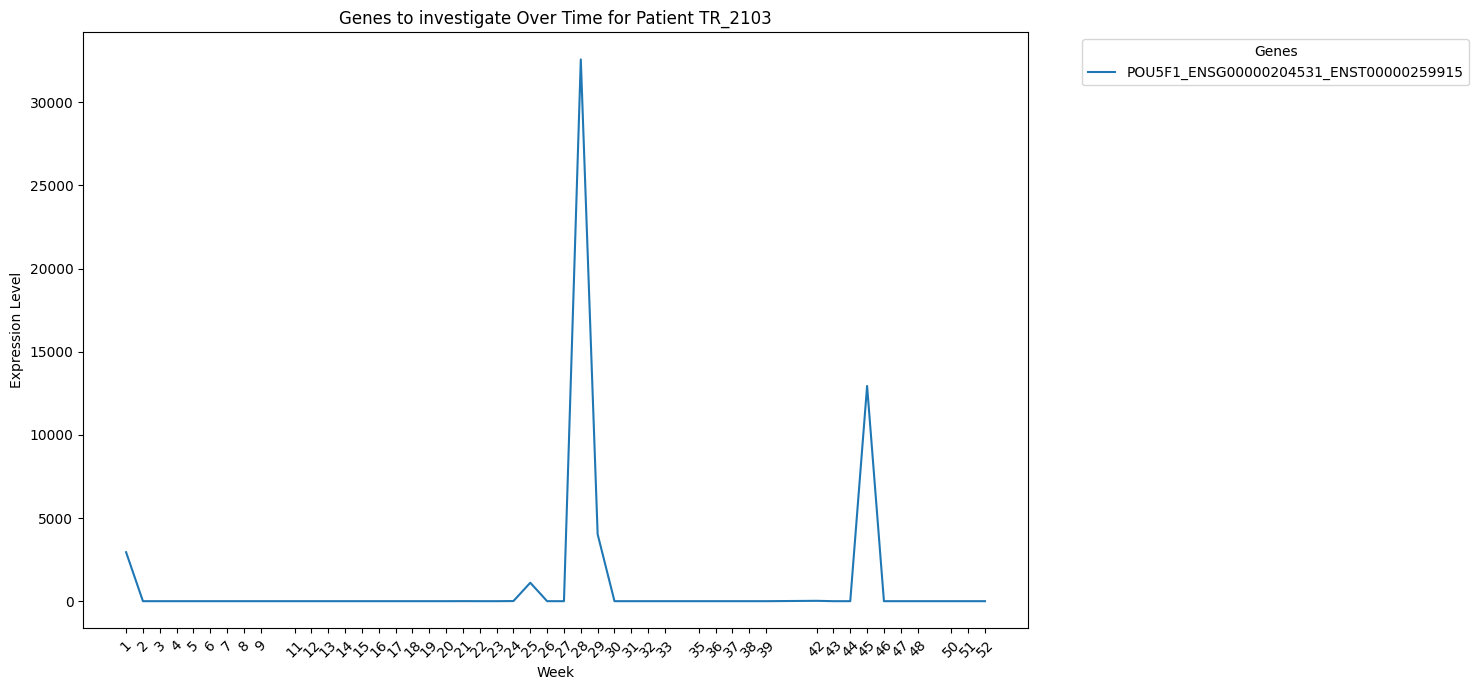

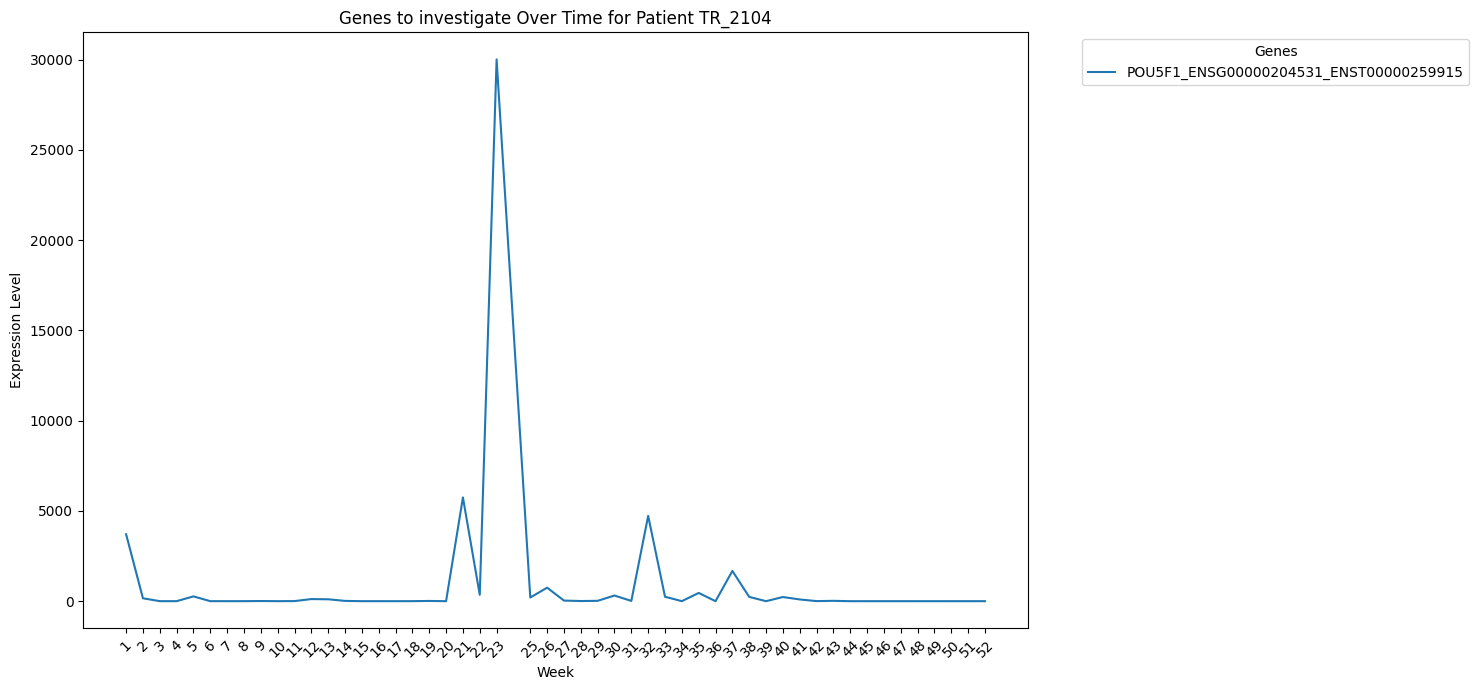

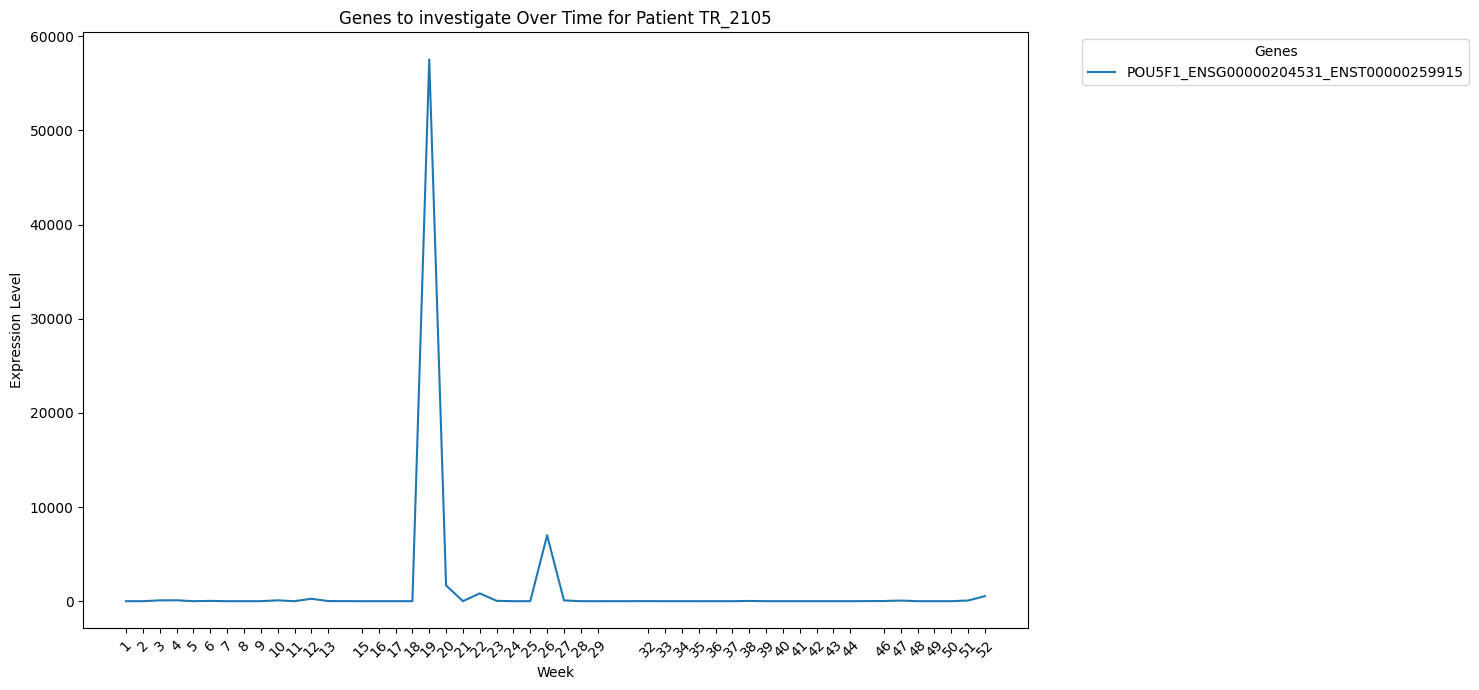

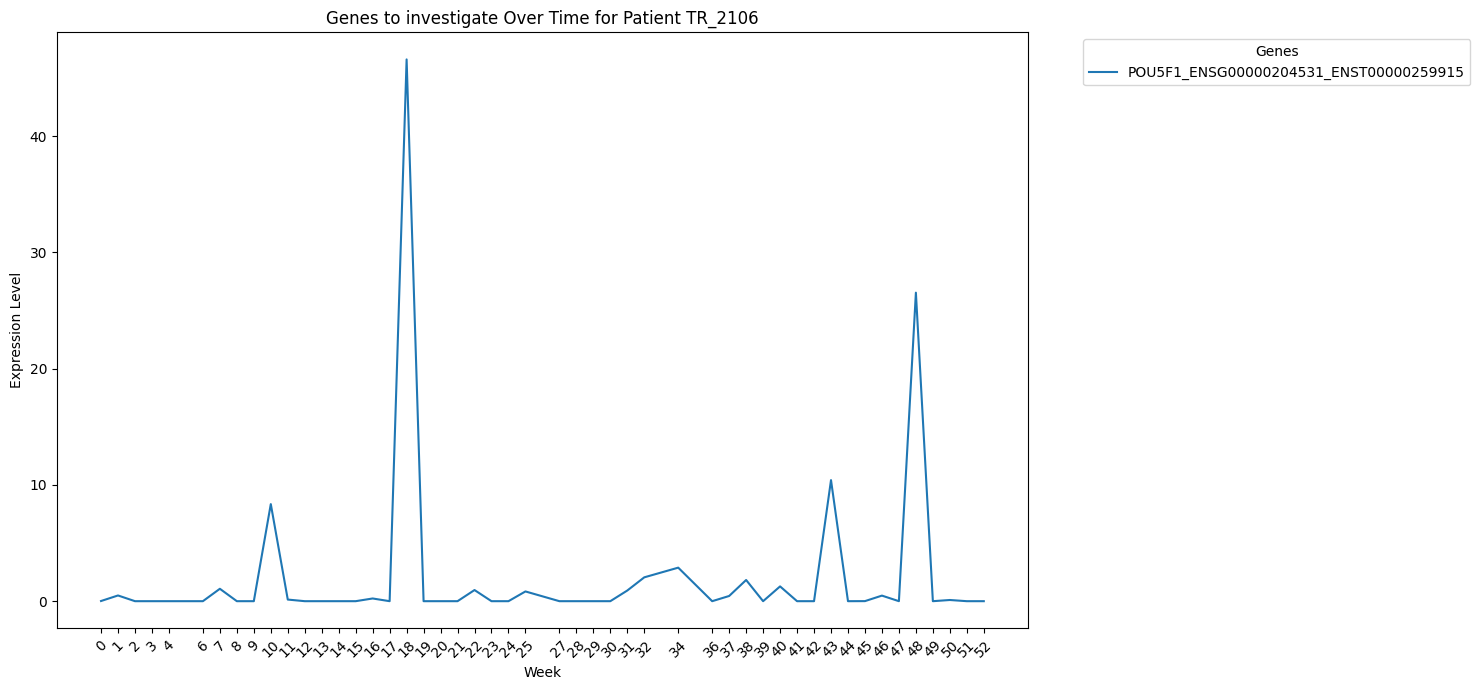

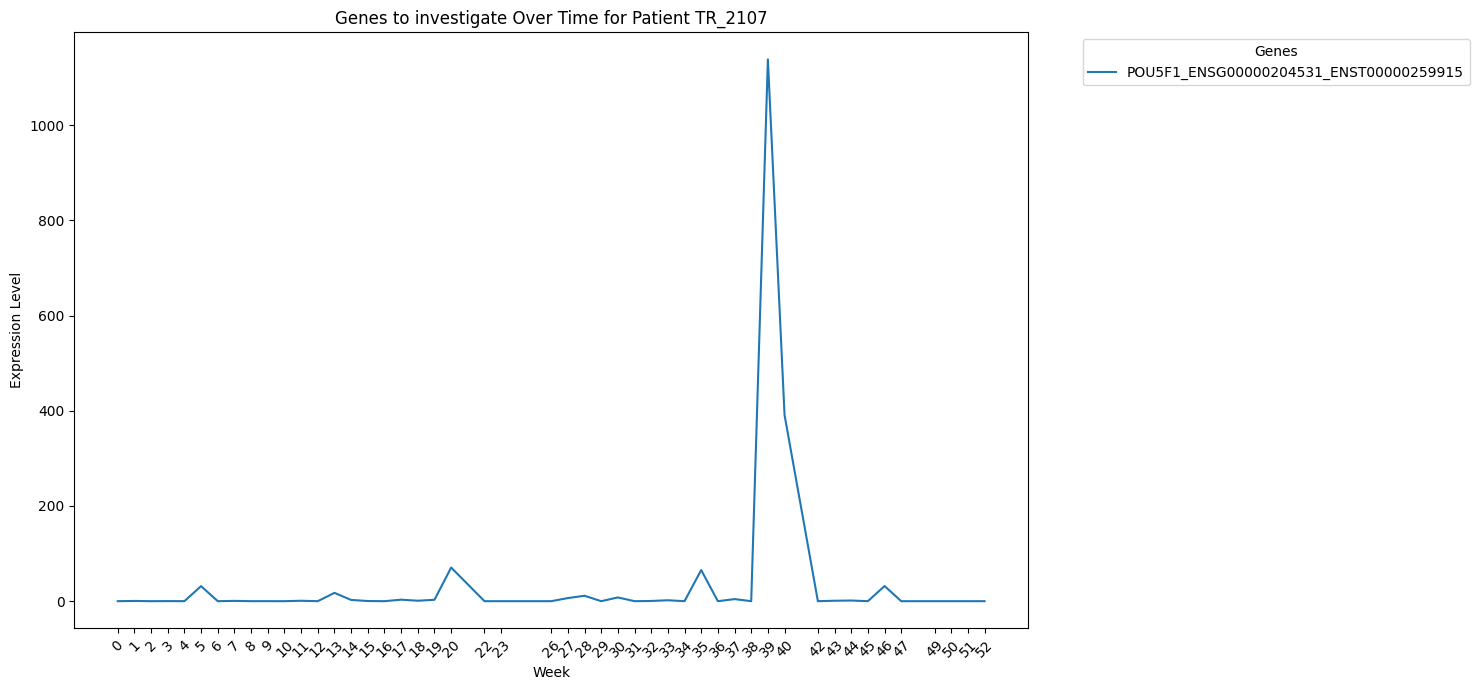

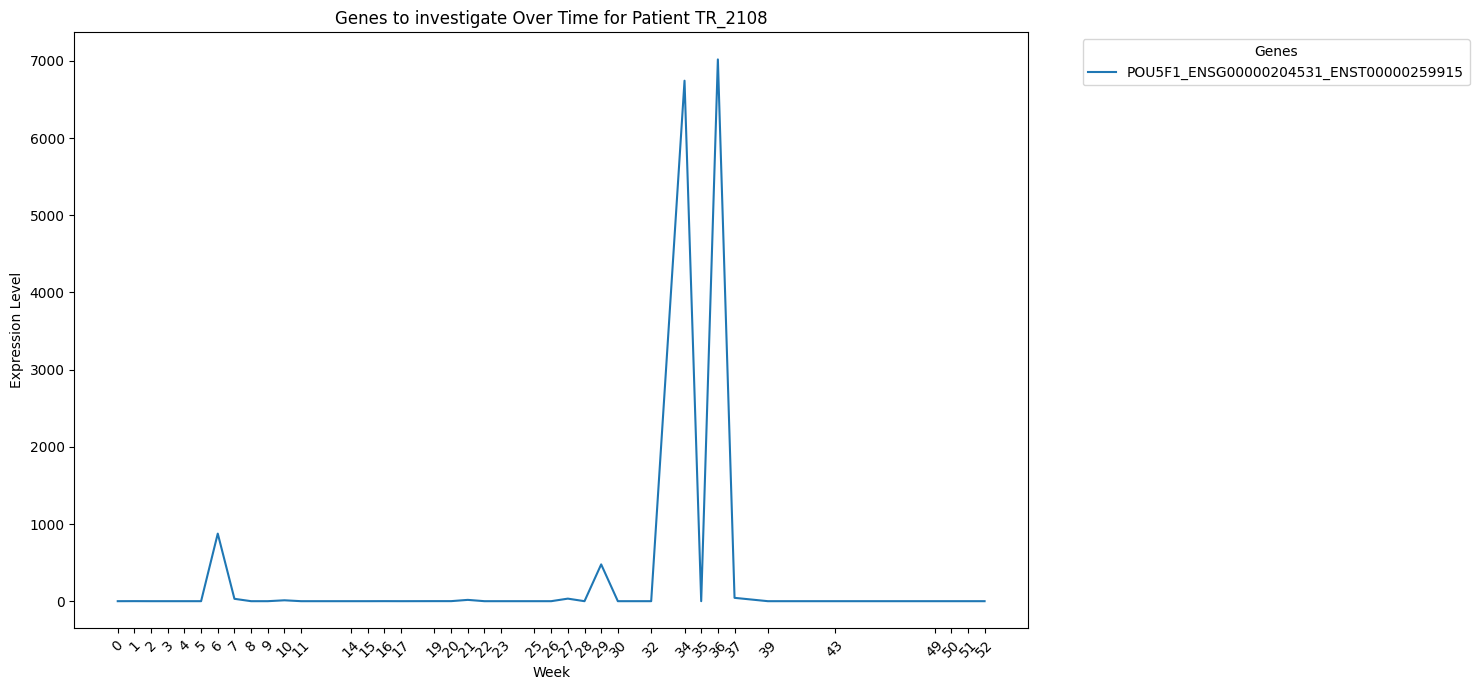

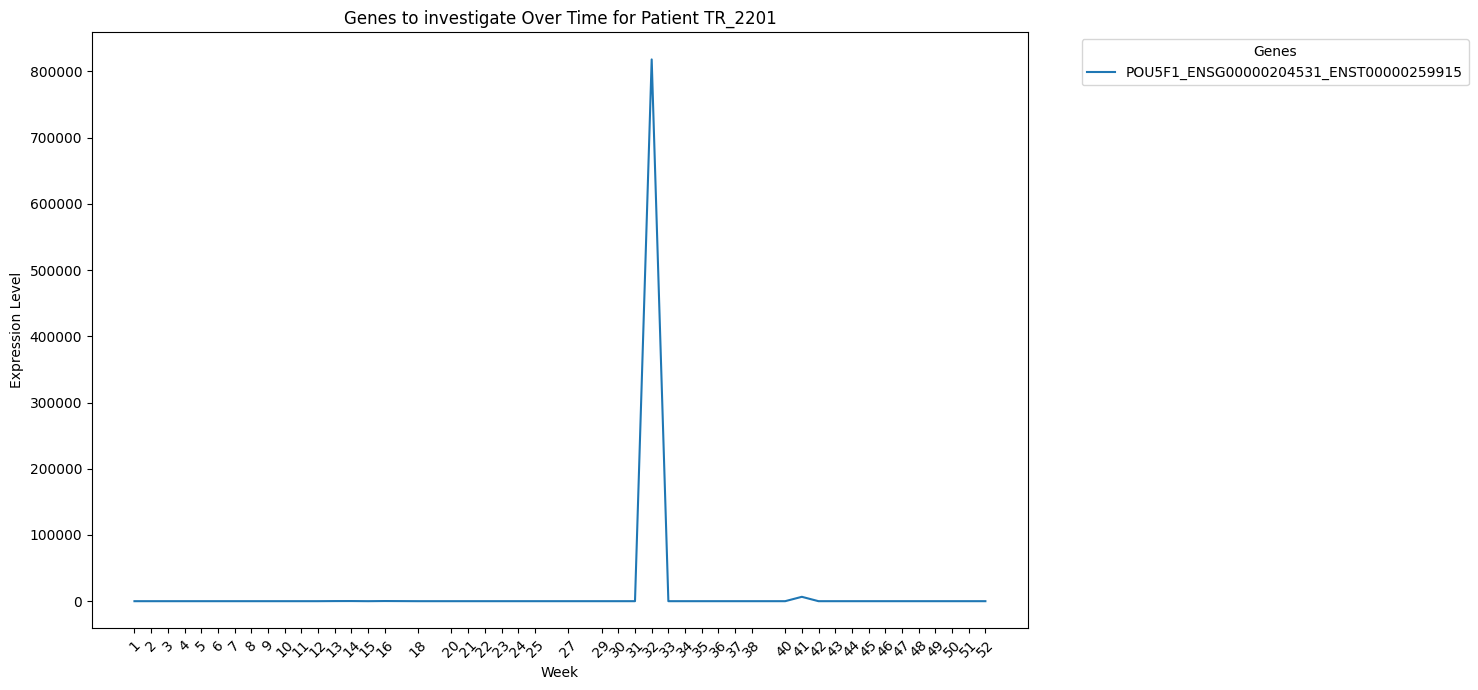

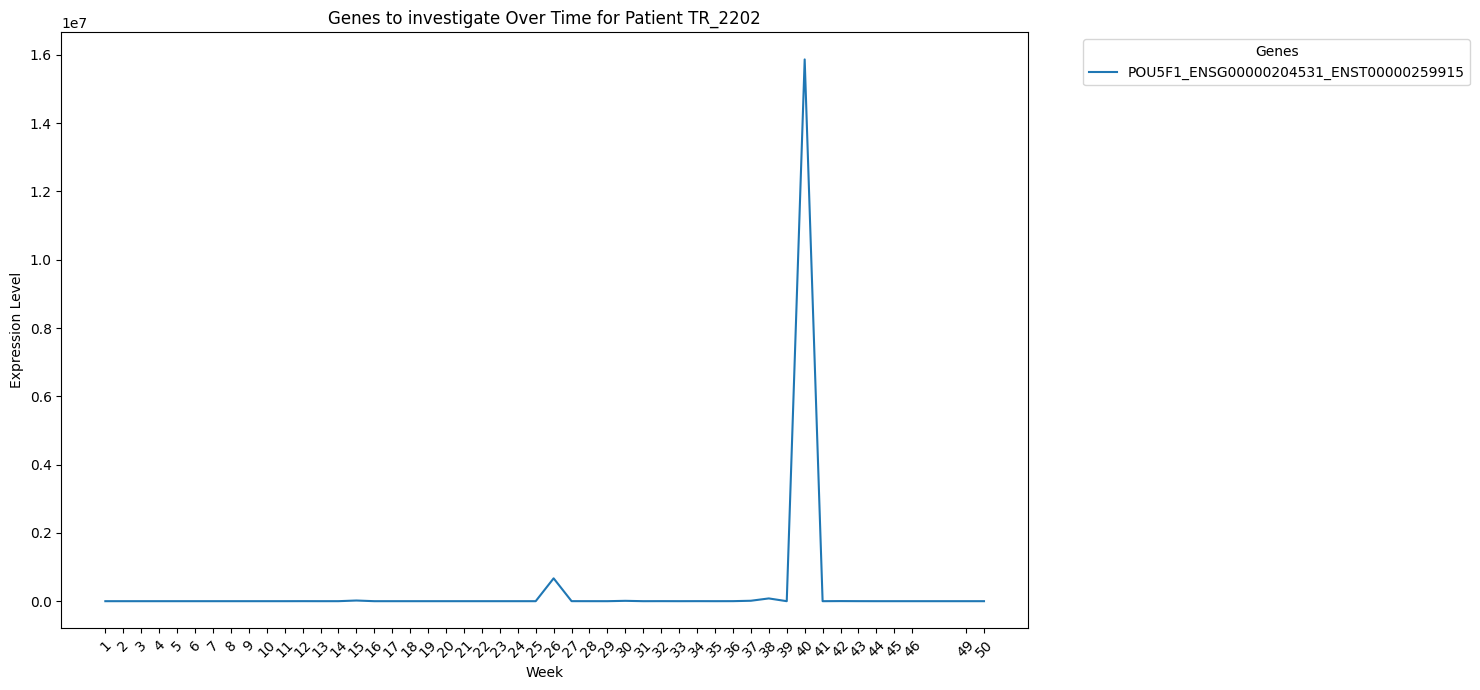

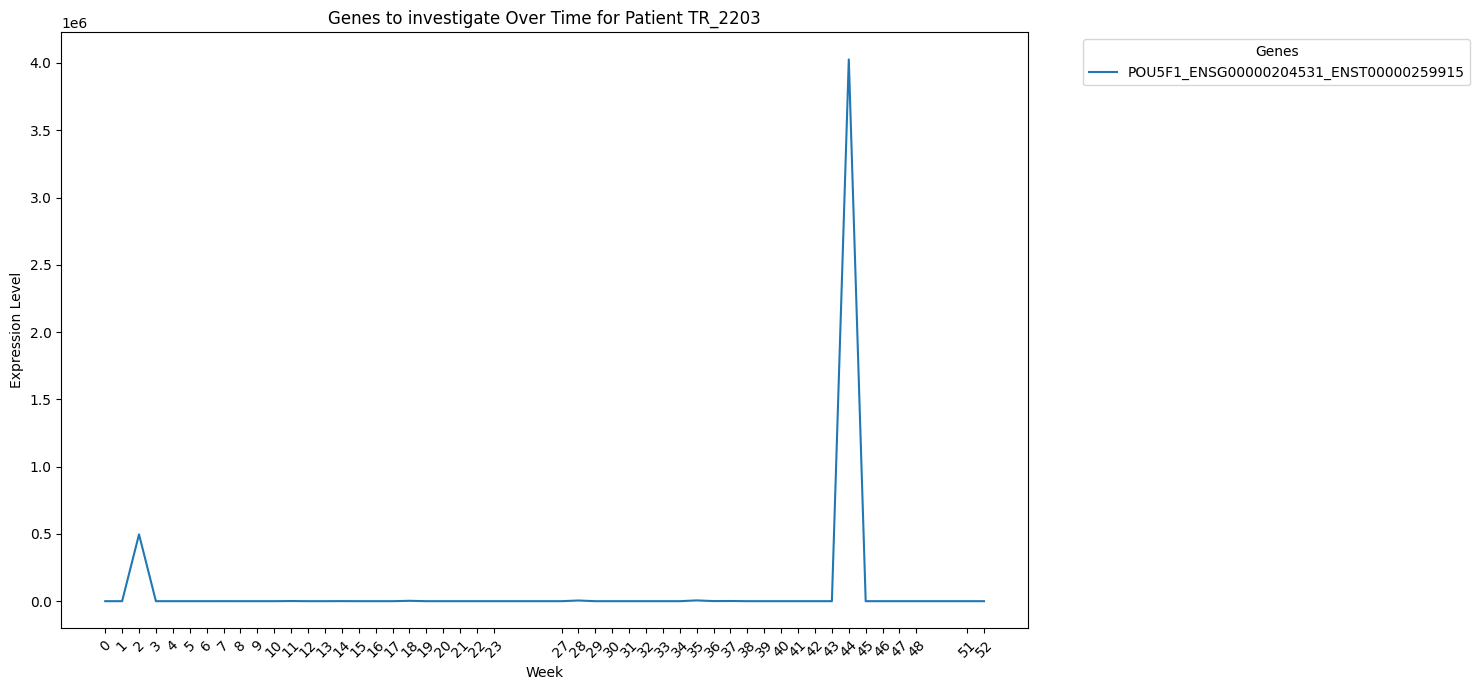

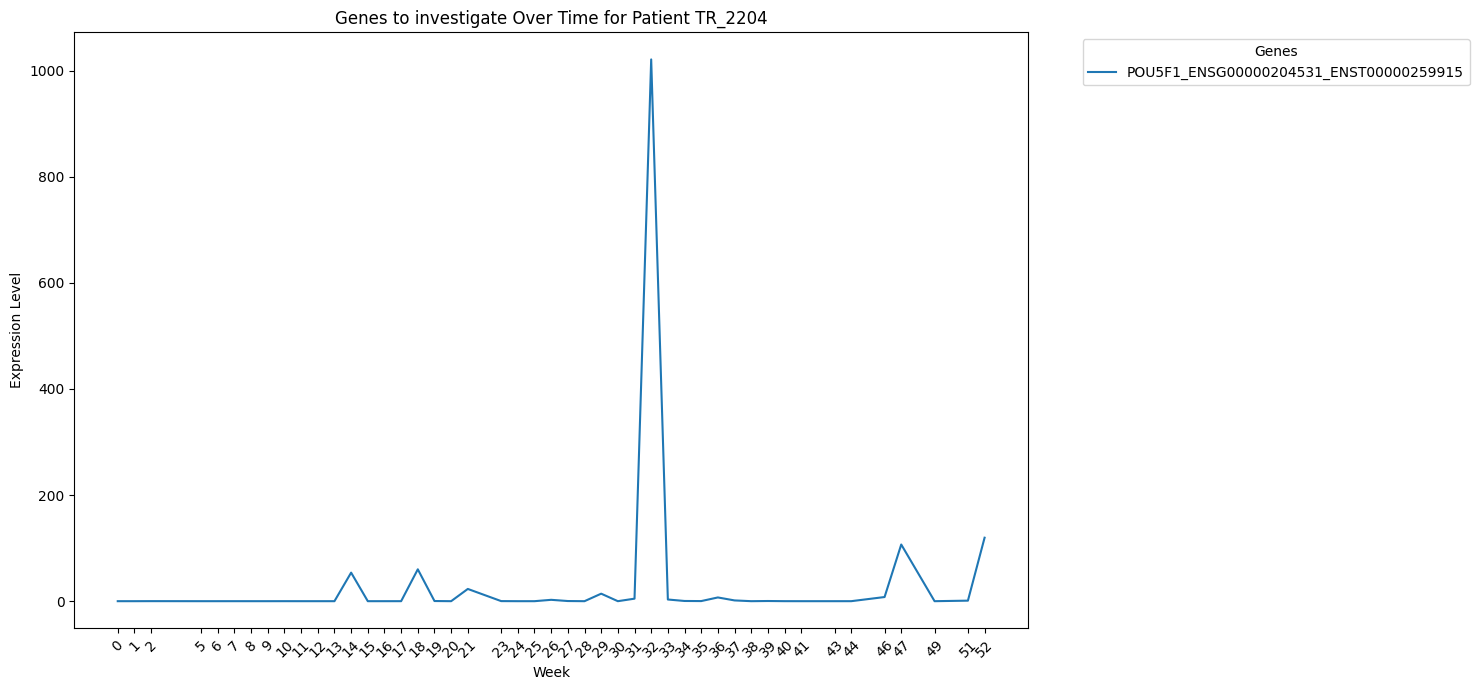

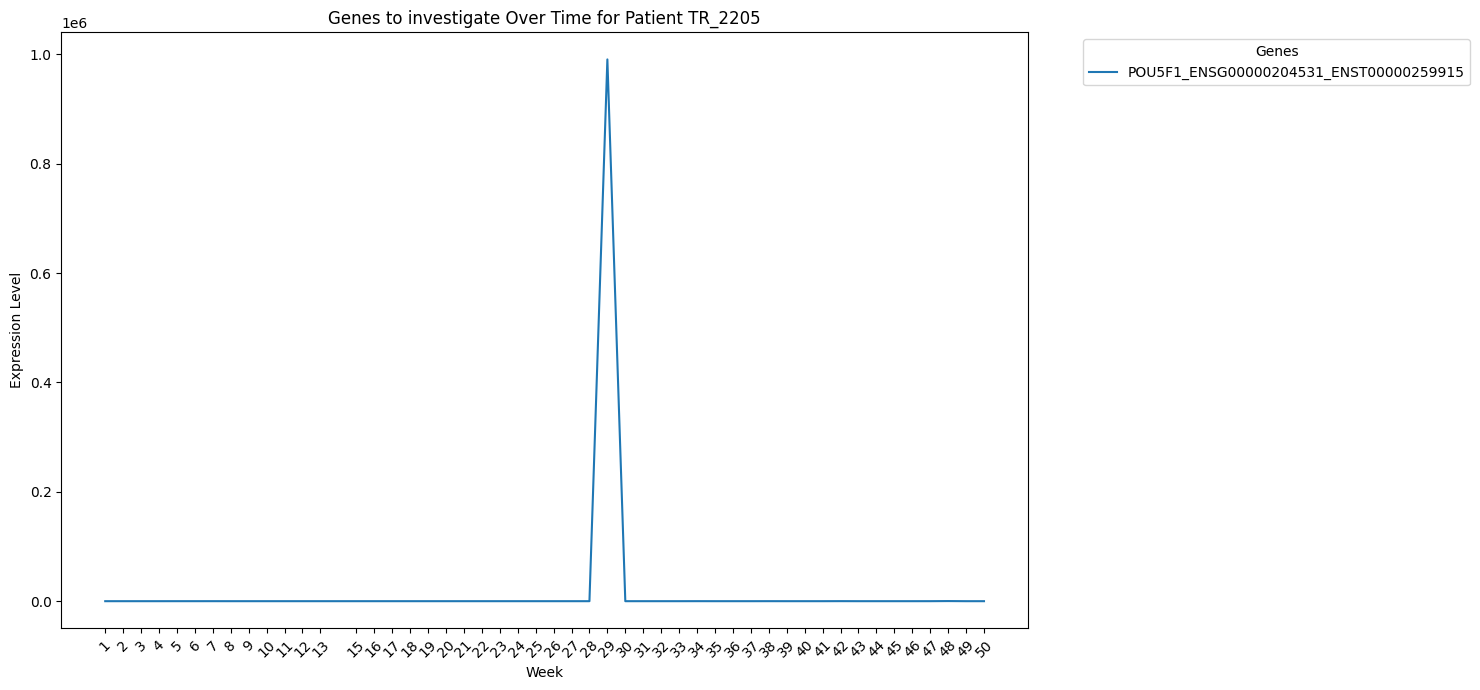

In [9]:
# @title Genes to investigate
for patient in gene_count_df['patient_id'].unique():
    patient_data = gene_count_df[gene_count_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-gene expression columns to focus on gene data
    #gene_data = patient_data.drop(['patient_id', 'week', 'Flare_status' , 'PatientID_Weeknr'], axis=1)
    gene_data = patient_data.drop(['patient_id', 'week',  'PatientID_Weeknr'], axis=1)

    # Find the 10 genes with the most variation (highest standard deviation) for the current patient
    top_genes = ['POU5F1_ENSG00000204531_ENST00000259915']

    plt.figure(figsize=(15, 7))

    # Plot the expression over time for the top 10 genes with the most variation
    for gene in top_genes:
        sns.lineplot(data=patient_data, x='week', y=gene, label=gene)

    # Annotate flare status changes (if applicable)
    #flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
    #for _, (week, status) in flare_changes.iterrows():
     #   plt.axvline(x=week, color='grey', linestyle='--')
     #  plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Genes to investigate Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Expression Level')
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [10]:
# @title Adding a Flare_start column
# Function to apply the flagging of the first flare week
def flag_first_flare_week(df):
    # Identify the rows where flare starts
    df['is_flare'] = df['Flare_status'] == 'During_flare'  # Adapt condition based on how flare is indicated in your dataset

    # Sort by patient and week to ensure the chronological order
    df.sort_values(by=['patient_id', 'week'], inplace=True)

    # Group by patient and use cumsum to identify the first flare
    df['flare_cumsum'] = df.groupby('patient_id')['is_flare'].cumsum()

    # Mark the first flare for each patient
    df['Flare_start'] = (df['flare_cumsum'] == 1) & df['is_flare']

    # Convert boolean to integer (1 for True, 0 for False)
    df['Flare_start'] = df['Flare_start'].astype(int)

    # Drop helper columns if they are no longer needed
    df.drop(['is_flare', 'flare_cumsum'], axis=1, inplace=True)

    return df

# Apply the function to both dataframes
gene_count_df = flag_first_flare_week(gene_count_df)


KeyError: 'Flare_status'

In [ ]:
# @title Segment time series function and execution
def segment_time_series(df, length=6):
    # Sort by patient and week to ensure chronological order
    df.sort_values(by=['patient_id', 'week'], inplace=True)

    # Create 'ts' column initialized to NaN
    df['ts'] = np.nan
    df['RBF'] = False

    # Process each patient individually
    for patient in df['patient_id'].unique():
        patient_data = df[df['patient_id'] == patient]

        # Check for the presence of a flare start
        flare_start_indices = patient_data[patient_data['Flare_start'] == 1].index.tolist()

        # Initial segment number
        ts_value = 1

        if flare_start_indices:
            # There is at least one flare start
            flare_start_index = flare_start_indices[0]  # Assume first flare start is the one to consider
            # Calculate the position of the first flare start
            flare_position = patient_data.index.get_loc(flare_start_index)

            # Calculate the length of the first segment to align flare start with a new segment start
            if flare_position % length == 0:
                first_segment_length = 0  # Flare start is already aligned with a new segment
            else:
                first_segment_length = flare_position % length

            # Assign time series IDs
            # Segment before flare start if it has any length
            if first_segment_length > 0:
                df.loc[patient_data.index[:first_segment_length], 'ts'] = ts_value
                ts_value += 1

            # Remaining data after the initial adjustment
            for i in range(first_segment_length, len(patient_data), length):
                df.loc[patient_data.index[i:i+length], 'ts'] = ts_value
                ts_value += 1

            df.loc[patient_data.index[flare_position - length:flare_position], 'RBF'] = True

        else:
            # No flare, segment normally every x points
            for i in range(0, len(patient_data), length):
                df.loc[patient_data.index[i:i+length], 'ts'] = ts_value
                ts_value += 1

    # Convert 'ts' column to integer
    df['ts'] = df['ts'].astype(int)

    # Create a new column combining 'ts' and 'patient_id'
    df['ts_patient_id'] = df['patient_id'] + '_TS' + df['ts'].astype(str)

    return df


# Apply the function to both dataframes
metaphlan_df = segment_time_series(metaphlan_df, 7)
gene_count_df = segment_time_series(gene_count_df, 7)

# Check the results
print(metaphlan_df[['patient_id', 'week', 'Flare_status', 'Flare_start', 'ts', 'ts_patient_id', 'RBF']])
print(gene_count_df[['patient_id', 'week', 'Flare_status', 'Flare_start', 'ts', 'ts_patient_id','RBF']])

In [ ]:
metaphlan_df[metaphlan_df["patient_id"]=="TR_2102"][["week","ts_patient_id","Flare_status"]]

In [ ]:
# @title Augmented Dickey-Fuller (ADF) test
def analyze_time_series(data, significance_level=0.05, mht="bonferroni", id_col="ts_patient_id"):
    #flare_patients = data[data['Flare_status']=="During_flare"]['patient_id'].unique()

    # Suppress runtime warnings from statsmodels or other calculations
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    filtered_df = data.groupby('ts_patient_id').filter(lambda x: len(x) > 4)

    # Define columns to analyze (excluding metadata columns)
    analyze_columns = [col for col in filtered_df.columns if col not in ['patient_id', 'week', 'Flare_status','Flare_start', 'ts', 'RBF', 'ts_patient_id']]

    # Prepare to store results
    adf_results = []

    # Perform ADF tests
    for id in filtered_df[id_col].unique():
        patient_data = filtered_df[filtered_df[id_col] == id]
        for column in analyze_columns:
            time_series = patient_data[column]
            if time_series.notna().all() and len(time_series) > 1 and time_series.var() > 0:
                try:
                    result = adfuller(time_series)
                    adf_results.append({
                        'id': id,
                        'variable': column,
                        'ADF Statistic': result[0],
                        'p-value': result[1],
                        'Used lag': result[2],
                        'Number of observations': result[3],
                        'Critical values': result[4],
                        'IC used': result[5]
                    })
                except Exception as e:
                    adf_results.append({
                        'id': id,
                        'variable': column,
                        'Error': str(e)
                    })
            else:
                adf_results.append({
                    'id': id,
                    'variable': column,
                    'Error': 'Insufficient data or variance'
                })

    # Convert results to DataFrame
    results_df = pd.DataFrame(adf_results)
    results_df['p-value'] = pd.to_numeric(results_df['p-value'], errors='coerce')

    # Apply multiple testing corrections
    _, bh_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='fdr_bh')
    _, bonf_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='bonferroni')

    results_df['bh_adjusted_p-value'] = pd.Series(bh_adjusted, index=results_df['p-value'].dropna().index)
    results_df['bonferroni_adjusted_p-value'] = pd.Series(bonf_adjusted, index=results_df['p-value'].dropna().index)

    # Filter significant results
    if mht == "bonferroni":
      significant_results = results_df[results_df['bonferroni_adjusted_p-value'] < significance_level]
    elif mht == "bh" :
      significant_results = results_df[results_df['bh_adjusted_p-value'] < significance_level]

    # Print results
    significant_counts = significant_results.groupby('id').size()
    print("Summary of significant adjusted p-value counts by sub-timeseries:")
    print(significant_counts)

    for id, count in significant_counts.items():
        print(f"Patient ID: {id}")
        print(f"Number of variables with significant adjusted p-values: {count}")
        patient_vars = significant_results[significant_results['id'] == id]
        for index, row in patient_vars.iterrows():
          if mht == "bonferroni":
            print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bonferroni_adjusted_p-value']:.5f}")
          elif mht == "bh" :
            print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bh_adjusted_p-value']:.5f}")
        print("\n")  # Add a new line for readability

    #target_ids = filtered_df[filtered_df["RBF"]==True]['ts_patient_id'].unique()
    target_ids= ['TR_2101_TS4', 'TR_2102_TS2']

    # Find and print variables significant across specific target patient IDs
    target_significant = significant_results[significant_results['id'].isin(target_ids)]
    common_significant_vars = target_significant.groupby('variable').filter(lambda x: len(x) == len(target_ids))

    if not common_significant_vars.empty:
        print("\nVariables significant across all specified target patient IDs:")
        for variable in common_significant_vars['variable'].unique():
            print(f"Variable: {variable}")
            relevant_patients = significant_results[significant_results['variable'] == variable]
            other_patients = relevant_patients[~relevant_patients['id'].isin(target_ids)]
            print(f"Significant in target IDs: {', '.join(target_ids)}")
            if not other_patients.empty:
                print(f"Also significant in other patient IDs: {', '.join(other_patients['id'].unique())}")
            else:
                print("Not significant in any other patient IDs.")
    else:
        print("No variables are significant across all specified target patient IDs.")

    print("\n")  # Add a new line for readability

In [ ]:
analyze_time_series(metaphlan_df, 0.1, "bonferroni")

In [ ]:
analyze_time_series(gene_count_df, 0.1, "bonferroni")

In [ ]:
# @title Analyze time series initial function
# def analyze_time_series(data, significance_level=0.05, mht="bonferroni"):
#     flare_status="Pre_flare"
#     patient_ids = ["TR_2201", "TR_2202"]

#     # Suppress runtime warnings from statsmodels or other calculations
#     warnings.filterwarnings('ignore', category=RuntimeWarning)

#     # Filter the DataFrame safely
#     filtered_df = data.copy()[(data['patient_id'].isin(patient_ids)) | (data['Flare_status'] == flare_status)]

#     # Modify the patient_id based on the week
#     def modify_patient_id(row):
#         if row['patient_id'] in patient_ids:
#             suffix = "_1" if row['week'] < 25 else "_2"
#             return f"{row['patient_id']}{suffix}"
#         else:
#             return row['patient_id']

#     filtered_df['patient_id'] = filtered_df.apply(modify_patient_id, axis=1)

#     # Define columns to analyze (excluding metadata columns)
#     analyze_columns = [col for col in filtered_df.columns if col not in ['patient_id', 'week', 'Flare_status']]

#     # Prepare to store results
#     adf_results = []

#     # Perform ADF tests
#     for patient_id in filtered_df['patient_id'].unique():
#         patient_data = filtered_df[filtered_df['patient_id'] == patient_id]
#         for column in analyze_columns:
#             time_series = patient_data[column]
#             if time_series.notna().all() and len(time_series) > 1 and time_series.var() > 0:
#                 try:
#                     result = adfuller(time_series)
#                     adf_results.append({
#                         'patient_id': patient_id,
#                         'variable': column,
#                         'ADF Statistic': result[0],
#                         'p-value': result[1],
#                         'Used lag': result[2],
#                         'Number of observations': result[3],
#                         'Critical values': result[4],
#                         'IC used': result[5]
#                     })
#                 except Exception as e:
#                     adf_results.append({
#                         'patient_id': patient_id,
#                         'variable': column,
#                         'Error': str(e)
#                     })
#             else:
#                 adf_results.append({
#                     'patient_id': patient_id,
#                     'variable': column,
#                     'Error': 'Insufficient data or variance'
#                 })

#     # Convert results to DataFrame
#     results_df = pd.DataFrame(adf_results)
#     results_df['p-value'] = pd.to_numeric(results_df['p-value'], errors='coerce')

#     # Apply multiple testing corrections
#     _, bh_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='fdr_bh')
#     _, bonf_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='bonferroni')

#     results_df['bh_adjusted_p-value'] = pd.Series(bh_adjusted, index=results_df['p-value'].dropna().index)
#     results_df['bonferroni_adjusted_p-value'] = pd.Series(bonf_adjusted, index=results_df['p-value'].dropna().index)

#     # Filter significant results
#     if mht == "bonferroni":
#       significant_results = results_df[results_df['bonferroni_adjusted_p-value'] < significance_level]
#     elif mht == "bh" :
#       significant_results = results_df[results_df['bh_adjusted_p-value'] < significance_level]

#     # Print results
#     significant_counts = significant_results.groupby('patient_id').size()
#     print("Summary of significant adjusted p-value counts by patient:")
#     print(significant_counts)

#     for patient_id, count in significant_counts.items():
#         print(f"Patient ID: {patient_id}")
#         print(f"Number of variables with significant adjusted p-values: {count}")
#         patient_vars = significant_results[significant_results['patient_id'] == patient_id]
#         for index, row in patient_vars.iterrows():
#           if mht == "bonferroni":
#             print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bonferroni_adjusted_p-value']:.5f}")
#           elif mht == "bh" :
#             print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bh_adjusted_p-value']:.5f}")
#         print("\n")  # Add a new line for readability

#     target_ids = ['TR_2101', 'TR_2102', 'TR_2103']

#      # Find and print variables significant across specific target patient IDs
#     target_significant = significant_results[significant_results['patient_id'].isin(target_ids)]
#     common_significant_vars = target_significant.groupby('variable').filter(lambda x: len(x) == len(target_ids))

#     if not common_significant_vars.empty:
#         print("\nVariables significant across all specified target patient IDs:")
#         for variable in common_significant_vars['variable'].unique():
#             print(f"Variable: {variable}")
#             relevant_patients = significant_results[significant_results['variable'] == variable]
#             other_patients = relevant_patients[~relevant_patients['patient_id'].isin(target_ids)]
#             print(f"Significant in target IDs: {', '.join(target_ids)}")
#             if not other_patients.empty:
#                 print(f"Also significant in other patient IDs: {', '.join(other_patients['patient_id'].unique())}")
#             else:
#                 print("Not significant in any other patient IDs.")
#     else:
#         print("No variables are significant across all specified target patient IDs.")

#     print("\n")  # Add a new line for readability

In [ ]:
gene_count_df['patient_id'].value_counts()